In this project, we explored and analyzed data from NYC Taxi and Limousine Commission (TLC) in December 2018. We then built a classification model to determine whether a trip will be tipped. By interpreting the feature importances, we knew what types of trips are more likely to be tipped. 

We downloaded data from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).
Click **2018 --> June --> Green (CSV)**


The green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data dictionary can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None) # this will show all the columns in dataframe

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6]

%matplotlib inline

from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score

# skip all warnings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Preprocessing Data

Take a quick look at the dataset. First we loaded Green Taxi trip data on December, 2018. By explaining features one by one, we could understand the domain knowledge better. Besides, we also took a look at the shape of data as well as missing values.

In [3]:
# pandas load data
trips = pd.read_csv('E:/GitHub/DS701-1904/data/green_tripdata_2018-06.csv')

In [4]:
# shape of data
print (trips.shape)
# The first entry is # samples and the second entry is # features.

# read every feature in details
print (trips.columns.tolist())
len(trips.columns)

(739373, 19)
['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type']


19

In [5]:
trips.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2018-06-01 00:33:55   2018-06-01 00:36:13                  N   
1         2  2018-06-01 00:40:36   2018-06-01 00:49:46                  N   
2         2  2018-06-01 00:57:12   2018-06-01 01:02:58                  N   
3         2  2018-06-01 00:10:13   2018-06-01 00:16:27                  N   
4         1  2018-06-01 00:32:08   2018-06-01 00:52:06                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1            66            33                5           0.51   
1           1            25            49                5           1.97   
2           1            61            49                5           1.40   
3           1            49            97                1           1.36   
4           1            75           127                1           7.90   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0          4.0    0.5      0.5        0.70           0.0        NaN   
1          9.0    0.5      0.5        2.06           0.0        NaN   
2          6.5    0.5      0.5        0.00           0.0        NaN   
3          7.0    0.5      0.5        0.00           0.0        NaN   
4         24.0    0.5      0.5        6.30           0.0        NaN   

   improvement_surcharge  total_amount  payment_type  trip_type  
0                    0.3          6.00             1          1  
1                    0.3         12.36             1          1  
2                    0.3          7.80             2          1  
3                    0.3          8.30             2          1  
4                    0.3         31.60             1          1

* VendorID: LPEP provider that provided the data record (1 = Creative Mobile Technologies, LLC; 2=VeriFone Inc.)
* lpep_pickup_datetime: The time when meter was engaged
* lpep_dropoff_datetime: The time when meter was disengaged
* store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server
* RatecodeID: The final rate code in effect at the end of the trip.
* PULocationID: TLC taxi zone for pickup
* DOLocationID: TLC taxi zone for dropoff
* passenger_count: The number of passengers in the vehicle. Recorded by driver
* trip_distance: trip distance in miles
* fare_amount: The time-and-distance fare calculated by the meter
* extra: the 0.50 and 1 rush hour, and overnight charges
* mta_tax: 0.50 MTA tax that is automatically triggered based on the metered rate in use
* tip_amount: This field is automatically populated for credit card tips. **Cash tips are not included**
* tolls_amount: Total amount of all tolls paid in trip
* ehail_fee: NULL
* improvement_surcharge: 0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015
* total_amount: The total amount charged to passengers. **Does not include cash tips**
* payment_type: how the passenger paid for the trip
* trip_type: A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver

From the above description, we found an interesting thing that might affect the prediction of tips. We do not have cash tips information in the dataset. To make it closer to the Uber situation, we filter dataset with `payment_type = 1`, which is credit card. Then we report data shape and missing value.

In [6]:
# choose payment type as credit card
trips_cc = trips[trips['payment_type']==1]

# data shape again
print (trips_cc.shape)

# missing value
trips_cc.isnull().sum()

(417076, 19)


VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
passenger_count               0
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                417076
improvement_surcharge         0
total_amount                  0
payment_type                  0
trip_type                     0
dtype: int64

Nearly 40% of the data are removed. Even thought, the dataset is large enough to make prediction.

To see the missing value, data is actually pretty clean, with no missing value except feature 'ehail_fee', which contains all missing value and should be removed. The dataset is clean because we only choose "credit card" payment type. Some other missing values may occur at other payment type.

Besides, `VendorID` is the id-like variable and should also be removed. Since we already choose credit card, `payment_type` can be removed.

In [7]:
# data cleaning

# remove ehail_fee, VendorID and payment_type
trips_cc.drop(['ehail_fee', 'VendorID', 'payment_type'], axis=1, inplace=True)
trips_cc.shape

(417076, 16)

# Exploratory Data Analysis

In this section, we ran Exploratory Data Analysis on our dataset. In EDA, we should find some correlations between features and target variable, which was not defined in our dataset. Therefore, we derived a new variable `is_tipped`, to be our response variable. 

We implemented this from `tip_amount`. That is, set `is_tipped` to 0, if `tip_amount` is 0. Else, set it to 1.

## Tip Amount

In [8]:
trips_cc['tip_amount'].describe()

count    417076.000000
mean          1.814595
std           2.438583
min          -0.430000
25%           0.000000
50%           1.460000
75%           2.640000
max         444.440000
Name: tip_amount, dtype: float64

Negative values are found, which makes no sense! There are several things we can do about it:

* Find out samples with negative tip amount
* Compute number of those samples
* Remove them or impute with 0

There is only one sample with tip amount less than 0. We can definitely remove it. By looking at this sample, I might say that this negative `fare_amount` and `tip_amount` are due to the order cancellation from driver. But additional information is needed, if we want to know details. 

In [9]:
# number of samples with tip amount less than 0
print (sum(trips_cc['tip_amount']<0))

# sample
trips_cc[trips_cc['tip_amount']<0]

1


lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
531949  2018-06-22 17:44:12   2018-06-22 17:44:26                  N   

        RatecodeID  PULocationID  DOLocationID  passenger_count  \
531949           1           244           244                1   

        trip_distance  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
531949           0.01         -2.5   -1.0     -0.5       -0.43           0.0   

        improvement_surcharge  total_amount  trip_type  
531949                   -0.3         -6.68          1

In [10]:
# remove it
trips_cc = trips_cc[trips_cc['tip_amount']>=0]

## Target: is_tipped

We created a new feature `is_tipped` from `tip_amount`. Then we explored the distribution of `is_tipped`.

In [11]:
# create a new feature, named is_tipped
trips_cc['is_tipped'] = trips_cc['tip_amount'].apply(lambda x: 0 if x == 0 else 1)
trips_cc.head(10)

lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  RatecodeID  \
0   2018-06-01 00:33:55   2018-06-01 00:36:13                  N           1   
1   2018-06-01 00:40:36   2018-06-01 00:49:46                  N           1   
4   2018-06-01 00:32:08   2018-06-01 00:52:06                  N           1   
5   2018-06-01 00:15:35   2018-06-01 00:27:44                  N           1   
6   2018-06-01 00:49:03   2018-06-01 00:57:26                  N           1   
7   2018-06-01 00:49:31   2018-06-01 01:38:02                  N           1   
8   2018-06-01 00:16:57   2018-06-01 00:22:05                  N           1   
9   2018-06-01 00:42:02   2018-06-01 00:46:15                  N           1   
10  2018-06-01 00:11:58   2018-06-01 00:22:47                  N           1   
12  2018-06-01 00:22:02   2018-06-01 00:28:08                  N           1   

    PULocationID  DOLocationID  passenger_count  trip_distance  fare_amount  \
0             66            33                5           0.51          4.0   
1             25            49                5           1.97          9.0   
4             75           127                1           7.90         24.0   
5             36           112                2           2.90         11.0   
6            256            49                1           2.60          9.5   
7             25            28                2          14.64         45.0   
8            179           179                1           0.90          5.5   
9            179           179                2           0.90          5.5   
10             7           129                1           2.00          9.5   
12           256            17                2           1.10          6.0   

    extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
0     0.5      0.5        0.70           0.0                    0.3   
1     0.5      0.5        2.06           0.0                    0.3   
4     0.5      0.5        6.30           0.0                    0.3   
5     0.5      0.5        2.00           0.0                    0.3   
6     0.5      0.5        2.15           0.0                    0.3   
7     0.5      0.5        0.00           0.0                    0.3   
8     0.5      0.5        2.00           0.0                    0.3   
9     0.5      0.5        2.00           0.0                    0.3   
10    0.5      0.5        2.00           0.0                    0.3   
12    0.5      0.5        1.45           0.0                    0.3   

    total_amount  trip_type  is_tipped  
0           6.00          1          1  
1          12.36          1          1  
4          31.60          1          1  
5          14.30          1          1  
6          12.95          1          1  
7          46.30          1          0  
8           8.80          1          1  
9           8.80          1          1  
10         12.80          1          1  
12          8.75          1          1

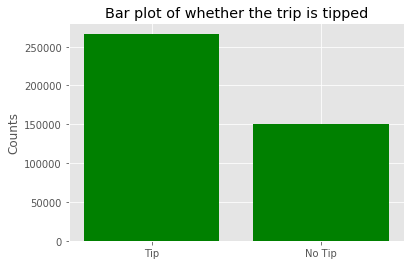

In [12]:
# Bar plot
x_pos = ['Tip','No Tip']
x = trips_cc['is_tipped'].value_counts()

plt.bar(x_pos, x, color='green')
plt.ylabel("Counts")
plt.title("Bar plot of whether the trip is tipped")
plt.show()

The distribution of data is balanced. At least, we do not worry about the imbalance problem in classification model.

## Total Amount

We explored a continuous variable. We saw the distribution of `total_amount` also shows negative values. However, Green Taxi has a minimum total amount of 2.5. So, we believe the records with total amount less than 2.5 are considered outliers. There are 246 outliers in total. As our total sample size is 417076, we removed those outliers.

In [13]:
# total amount
print (trips_cc['total_amount'].describe())
print()

# number of samples with total amount less than 2.5
print (sum(trips_cc['total_amount']<=2.5))

count    417075.000000
mean         19.609732
std          14.619184
min          -4.300000
25%           9.960000
50%          14.800000
75%          23.920000
max         485.300000
Name: total_amount, dtype: float64

246


In [14]:
# remove outliers
trips_cc = trips_cc[trips_cc['total_amount']>2.5]

Histogram plot is to describe the distribution of a continuous variable. It is heavily right skewness. So took log transformation to make it clear.

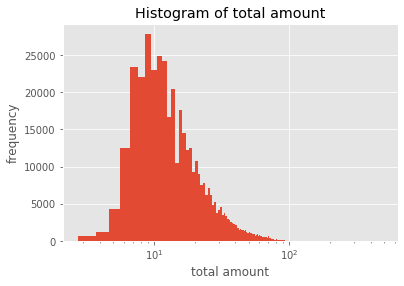

In [50]:
# the distribution of total amount
trips_cc['total_amount'].hist(bins=500)
plt.xlabel("total amount")
plt.ylabel("frequency")
plt.title("Histogram of total amount")
plt.xscale('log')
plt.show()

In [52]:
trips_cc.head()

lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  RatecodeID  \
0  2018-06-01 00:33:55   2018-06-01 00:36:13                  N           1   
1  2018-06-01 00:40:36   2018-06-01 00:49:46                  N           1   
4  2018-06-01 00:32:08   2018-06-01 00:52:06                  N           1   
5  2018-06-01 00:15:35   2018-06-01 00:27:44                  N           1   
6  2018-06-01 00:49:03   2018-06-01 00:57:26                  N           1   

   PULocationID  DOLocationID  passenger_count  trip_distance  fare_amount  \
0            66            33                5           0.51          4.0   
1            25            49                5           1.97          9.0   
4            75           127                1           7.90         24.0   
5            36           112                2           2.90         11.0   
6           256            49                1           2.60          9.5   

   extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
0    0.5      0.5        0.70           0.0                    0.3   
1    0.5      0.5        2.06           0.0                    0.3   
4    0.5      0.5        6.30           0.0                    0.3   
5    0.5      0.5        2.00           0.0                    0.3   
6    0.5      0.5        2.15           0.0                    0.3   

   total_amount  trip_type  is_tipped  
0          6.00          1          1  
1         12.36          1          1  
4         31.60          1          1  
5         14.30          1          1  
6         12.95          1          1

## Correlations

Previously we explored a single variable. In this section, we found the relationship between two features. Actually, we are interested in relation between each feature and the target. So see the numerical variables first. 

In [53]:
# feature name and data type
[(x, trips_cc[x].dtype) for x in trips_cc.columns]

[('lpep_pickup_datetime', dtype('O')),
 ('lpep_dropoff_datetime', dtype('O')),
 ('store_and_fwd_flag', dtype('O')),
 ('RatecodeID', dtype('int64')),
 ('PULocationID', dtype('int64')),
 ('DOLocationID', dtype('int64')),
 ('passenger_count', dtype('int64')),
 ('trip_distance', dtype('float64')),
 ('fare_amount', dtype('float64')),
 ('extra', dtype('float64')),
 ('mta_tax', dtype('float64')),
 ('tip_amount', dtype('float64')),
 ('tolls_amount', dtype('float64')),
 ('improvement_surcharge', dtype('float64')),
 ('total_amount', dtype('float64')),
 ('trip_type', dtype('int64')),
 ('is_tipped', dtype('int64'))]

In [54]:
# change int to object
int2obj = ['RatecodeID','PULocationID','DOLocationID','trip_type','is_tipped']
for c in int2obj:
    trips_cc[c] = trips_cc[c].astype(str)

In [55]:
# change int to float
int2float = ['passenger_count']
for c in int2float:
    trips_cc[c] = trips_cc[c].astype(float)

In [56]:
# filter numerical features
trips_numerical = trips_cc.select_dtypes(include = ['float64']).corr()

# print correlation coefs  between each feature and target
print(trips_numerical['tip_amount'].sort_values(ascending = False))

tip_amount               1.000000
total_amount             0.341942
trip_distance            0.177517
fare_amount              0.175508
tolls_amount             0.124722
extra                    0.069603
passenger_count          0.001758
improvement_surcharge   -0.034097
mta_tax                 -0.052042
Name: tip_amount, dtype: float64


We already knew that `is_tipped` is derived from `tip_amount`, which then should be removed from dataset. But we wanted to explore some other features that might have high correlation with `tip_amount`. 

* As we know, `fare amount` is recorded from the machine in Taxi, which is not the cause of tips. It should be included.
* `total amount` should be the total money a passenger pays for this trip. This feature contains the information of tips! If we want to predict tips, this feature should not appear in dataset. Otherwise, we are using y to predict y.

Still, we might wonder if tip amount has a high correlation with total amount minus fare amount.

As shown below, there is a high correlation between tip amount and total amount minus fare amount, which proves our previous analysis.

In [57]:
# coefficient
np.corrcoef(trips_numerical['tip_amount'], 
            trips_numerical['total_amount'] - trips_numerical['fare_amount'])

array([[1.        , 0.81891226],
       [0.81891226, 1.        ]])

# Feature Engineering

In this section, we prepared data for classification model. First we created time-related new features, using pickup and dropoff time. Second, we analyzed other features such as mta_tax, improvement surcharge and passenger count to get some insights. Third, we removed all irrelevant variables.

## Create New Features

The new features we created includes day of month, weekday, hour from pickup datetime. We also generated trip duration and trip speed, which are easy to get from original features. 

In [22]:
# TIME-RELATED

# convert lpep pickup datetime to standard datetime format
trips_cc['pickup_datetime'] = trips_cc['lpep_pickup_datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
# extract day of month
trips_cc['monthday'] = trips_cc['pickup_datetime'].apply(lambda x: x.day)
# get weekday
trips_cc['weekday'] = trips_cc['pickup_datetime'].apply(lambda x: x.weekday() + 1)
# get hour of day
trips_cc['hour'] = trips_cc['pickup_datetime'].apply(lambda x: x.hour)

In [23]:
# TRIP DURATION/SPEED

# derive Trip duration
trips_cc['dropoff_datetime'] = trips_cc['lpep_dropoff_datetime'].apply(
    lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
trips_cc['trip_duration'] = (trips_cc['dropoff_datetime'] - trips_cc['pickup_datetime']) / np.timedelta64(1, 'm')

# remove duration less than 0
trips_cc = trips_cc[trips_cc['trip_duration'] > 0]

# derive average trip speed with miles per hour
trips_cc['trip_speed'] = trips_cc['trip_distance'] / (trips_cc['trip_duration'] / 60.0)

# remove speed greater than 80
trips_cc = trips_cc[trips_cc['trip_speed'] <= 80]

## Other Features

By analyzing value counts of `mta_tax` and `improvement_surcharge` below, we saw the imbalance of the values. Thus these two features may not contribute much to the predictive models. But number of features here are small, so we still kept them in the dataset.

For `passenger_count`, we removed those 0-passenger samples. Besides, we set 6,7,8,9 as one level. 

In [24]:
# mta_tax
print (trips_cc['mta_tax'].value_counts())
print()
# improvement_surcharge
print (trips_cc['improvement_surcharge'].value_counts())
print()
# passenger_count
print (trips_cc['passenger_count'].value_counts())

# remove 0 passenger
trips_cc = trips_cc[trips_cc['passenger_count'] != 0]

# merge 7/8/9 to 6 
trips_cc['passenger_count'] = trips_cc['passenger_count'].apply(lambda x: 6 if x >= 6 else x)

0.5    411925
0.0      4410
Name: mta_tax, dtype: int64

0.3    412170
0.0      4165
Name: improvement_surcharge, dtype: int64

1.0    352556
2.0     31307
5.0     14702
6.0      7813
3.0      6807
4.0      2291
0.0       840
8.0        10
7.0         7
9.0         2
Name: passenger_count, dtype: int64


## Remove Irrelevant Variables

Datetime-related features are irrelevant. It makes no sense to add those variables to model. In addition, we had already extracted useful information from them. Thus we removed them.

Store_and_fwd_flag feature indicates whether the trip record was held in vehicle memory before sending to the vendor. This might differ because the vehicle did not have a connection to the server, which has no relationship with tip. We also removed it.

At last, tip amount and total amount should be removed, since it is response-related variable!

In [25]:
trips_cc.drop(['lpep_pickup_datetime',
               'lpep_dropoff_datetime',
               'pickup_datetime',
               'dropoff_datetime',
               'store_and_fwd_flag',
               'tip_amount', 'total_amount'],axis=1, inplace=True)

## Discretization 

In this section, we performed discretization of continuous features. Even though discretization may bring error, it decreases the effect of outliers and computational efforts.

* The pickup and dropoff location ID can be clustered into several district, based on the [taxi zone maps](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 
* `trip_duration`, `trip_speed`, `trip_distance` and `fare_amount` are highly right sknewed. Thus, we might take the log transformation, and bin with equal frequency.
* `mta_tax`, `improvement_surcharge` and `tolls_amount` both have a large number of 0. So we'd better convert them to binary variables (0/1).
* We labeled encoder `extra`.


### Locations

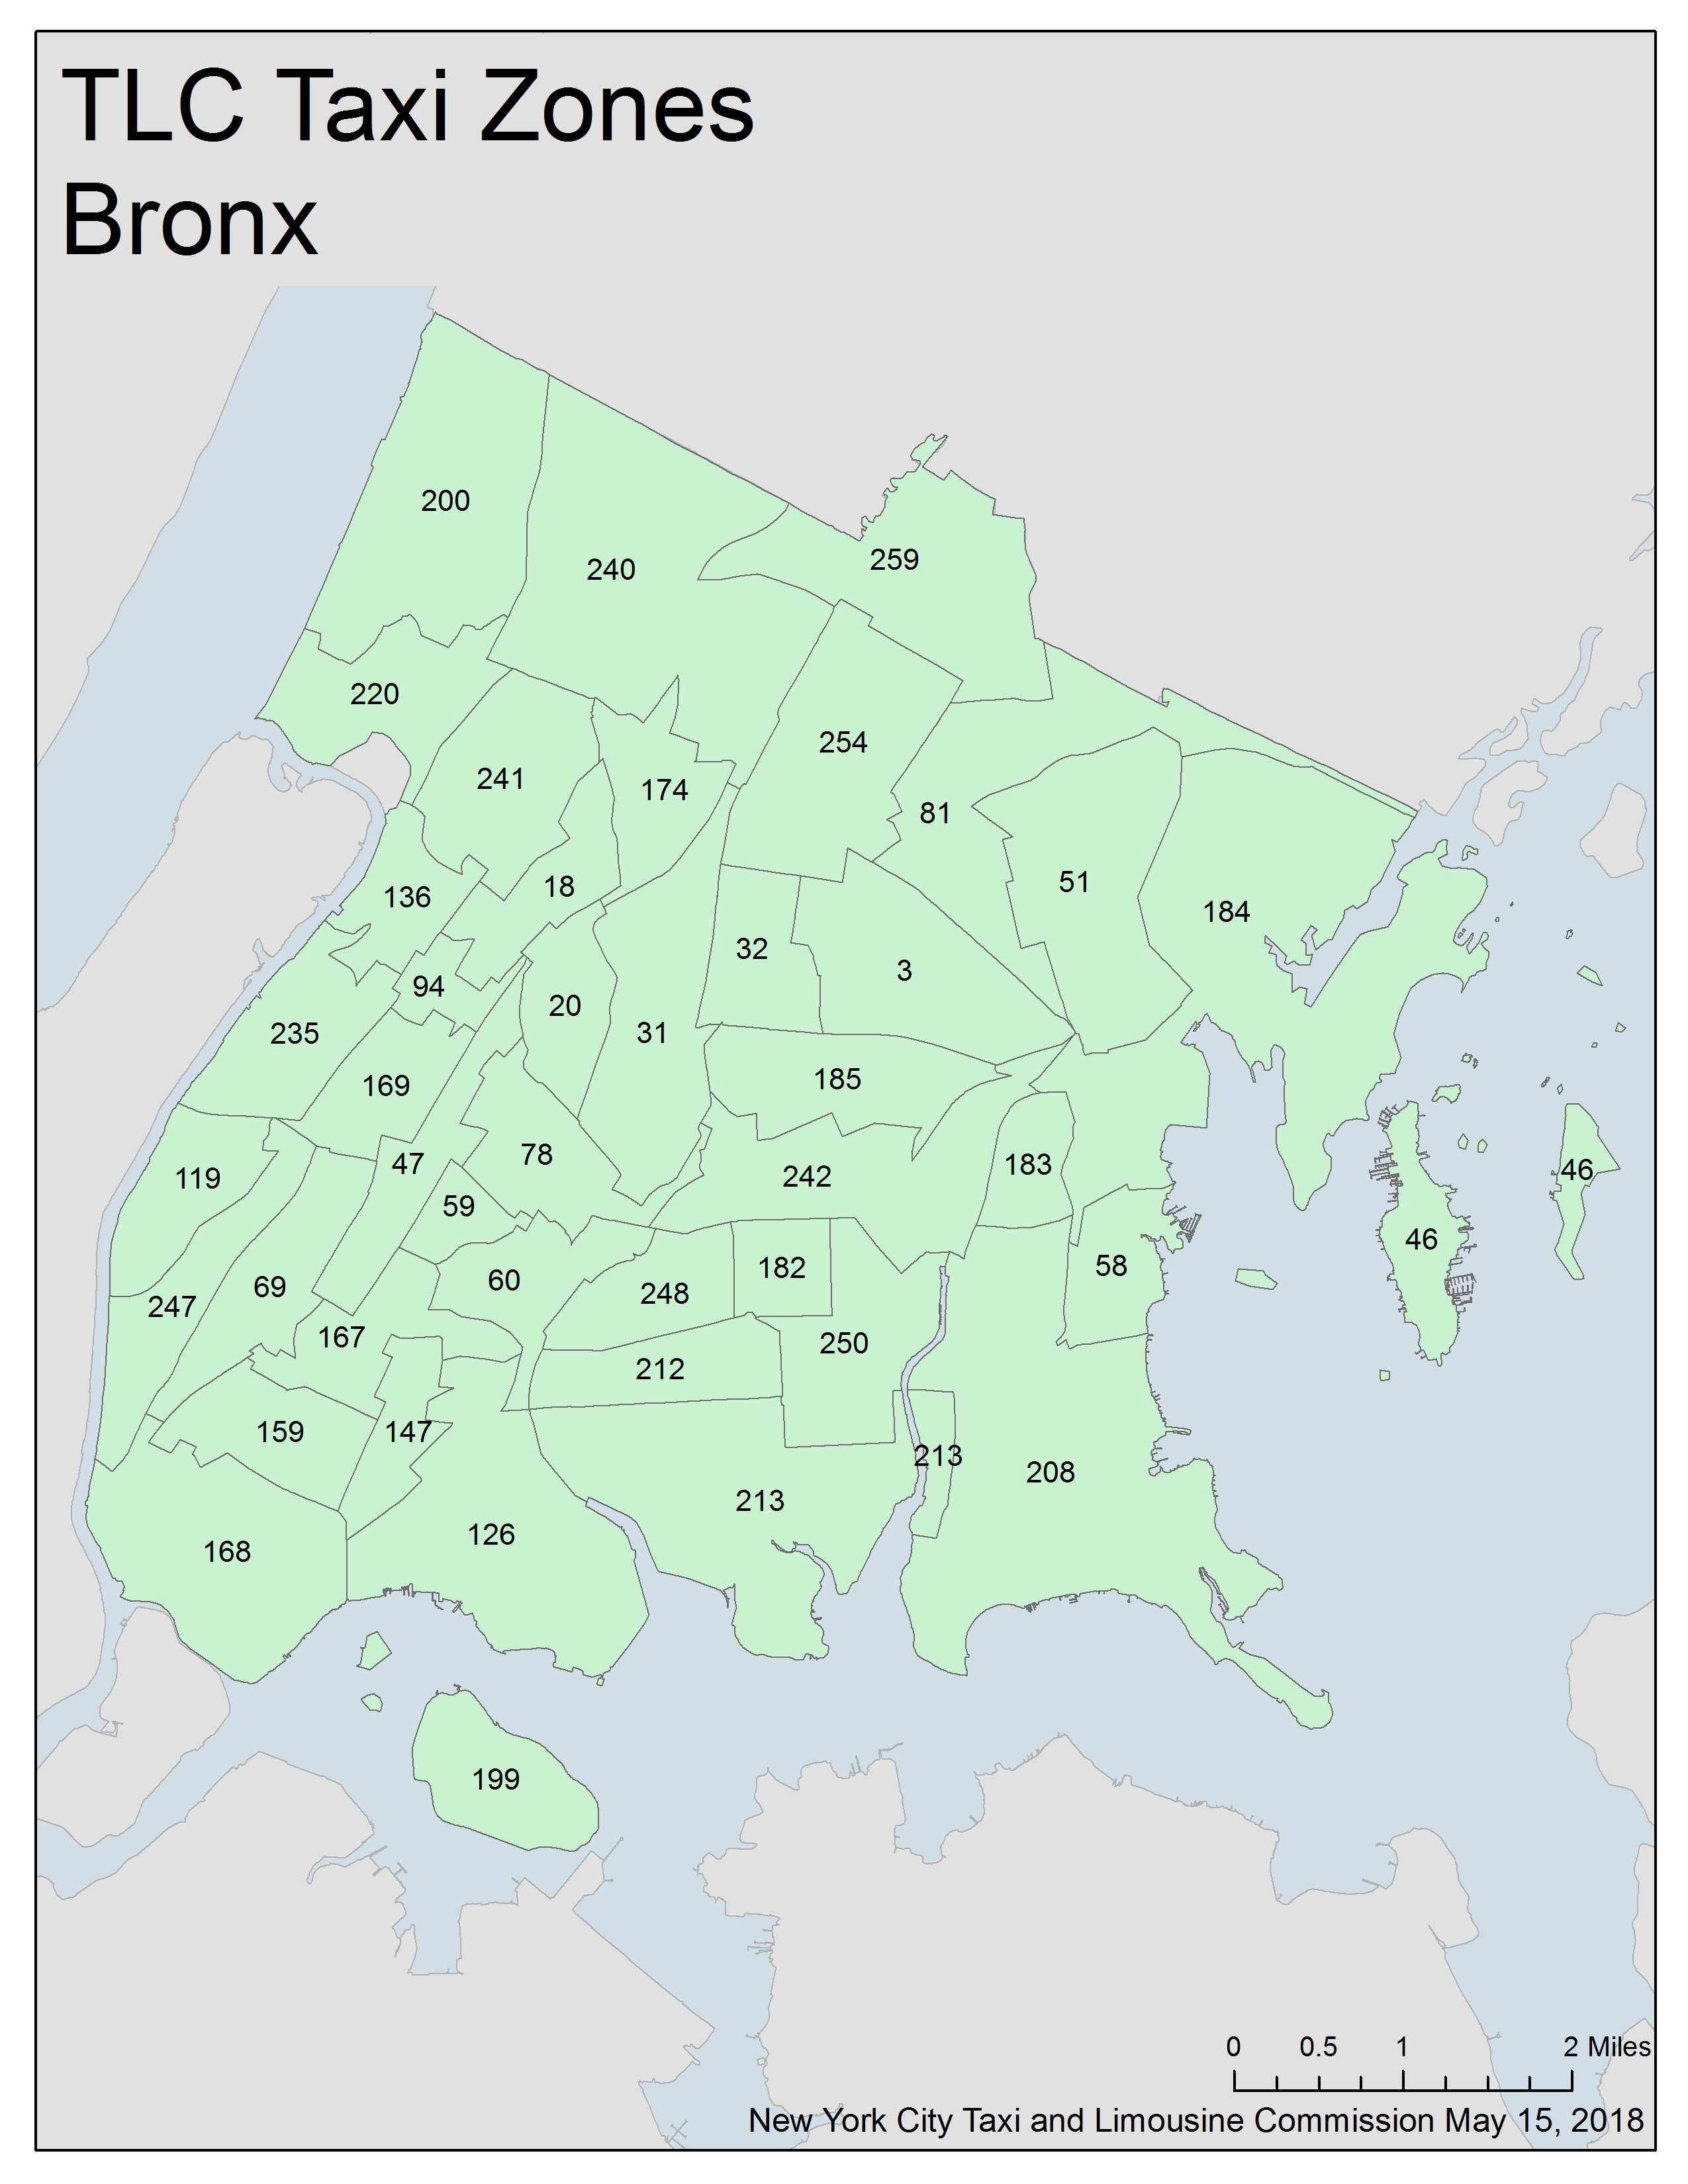

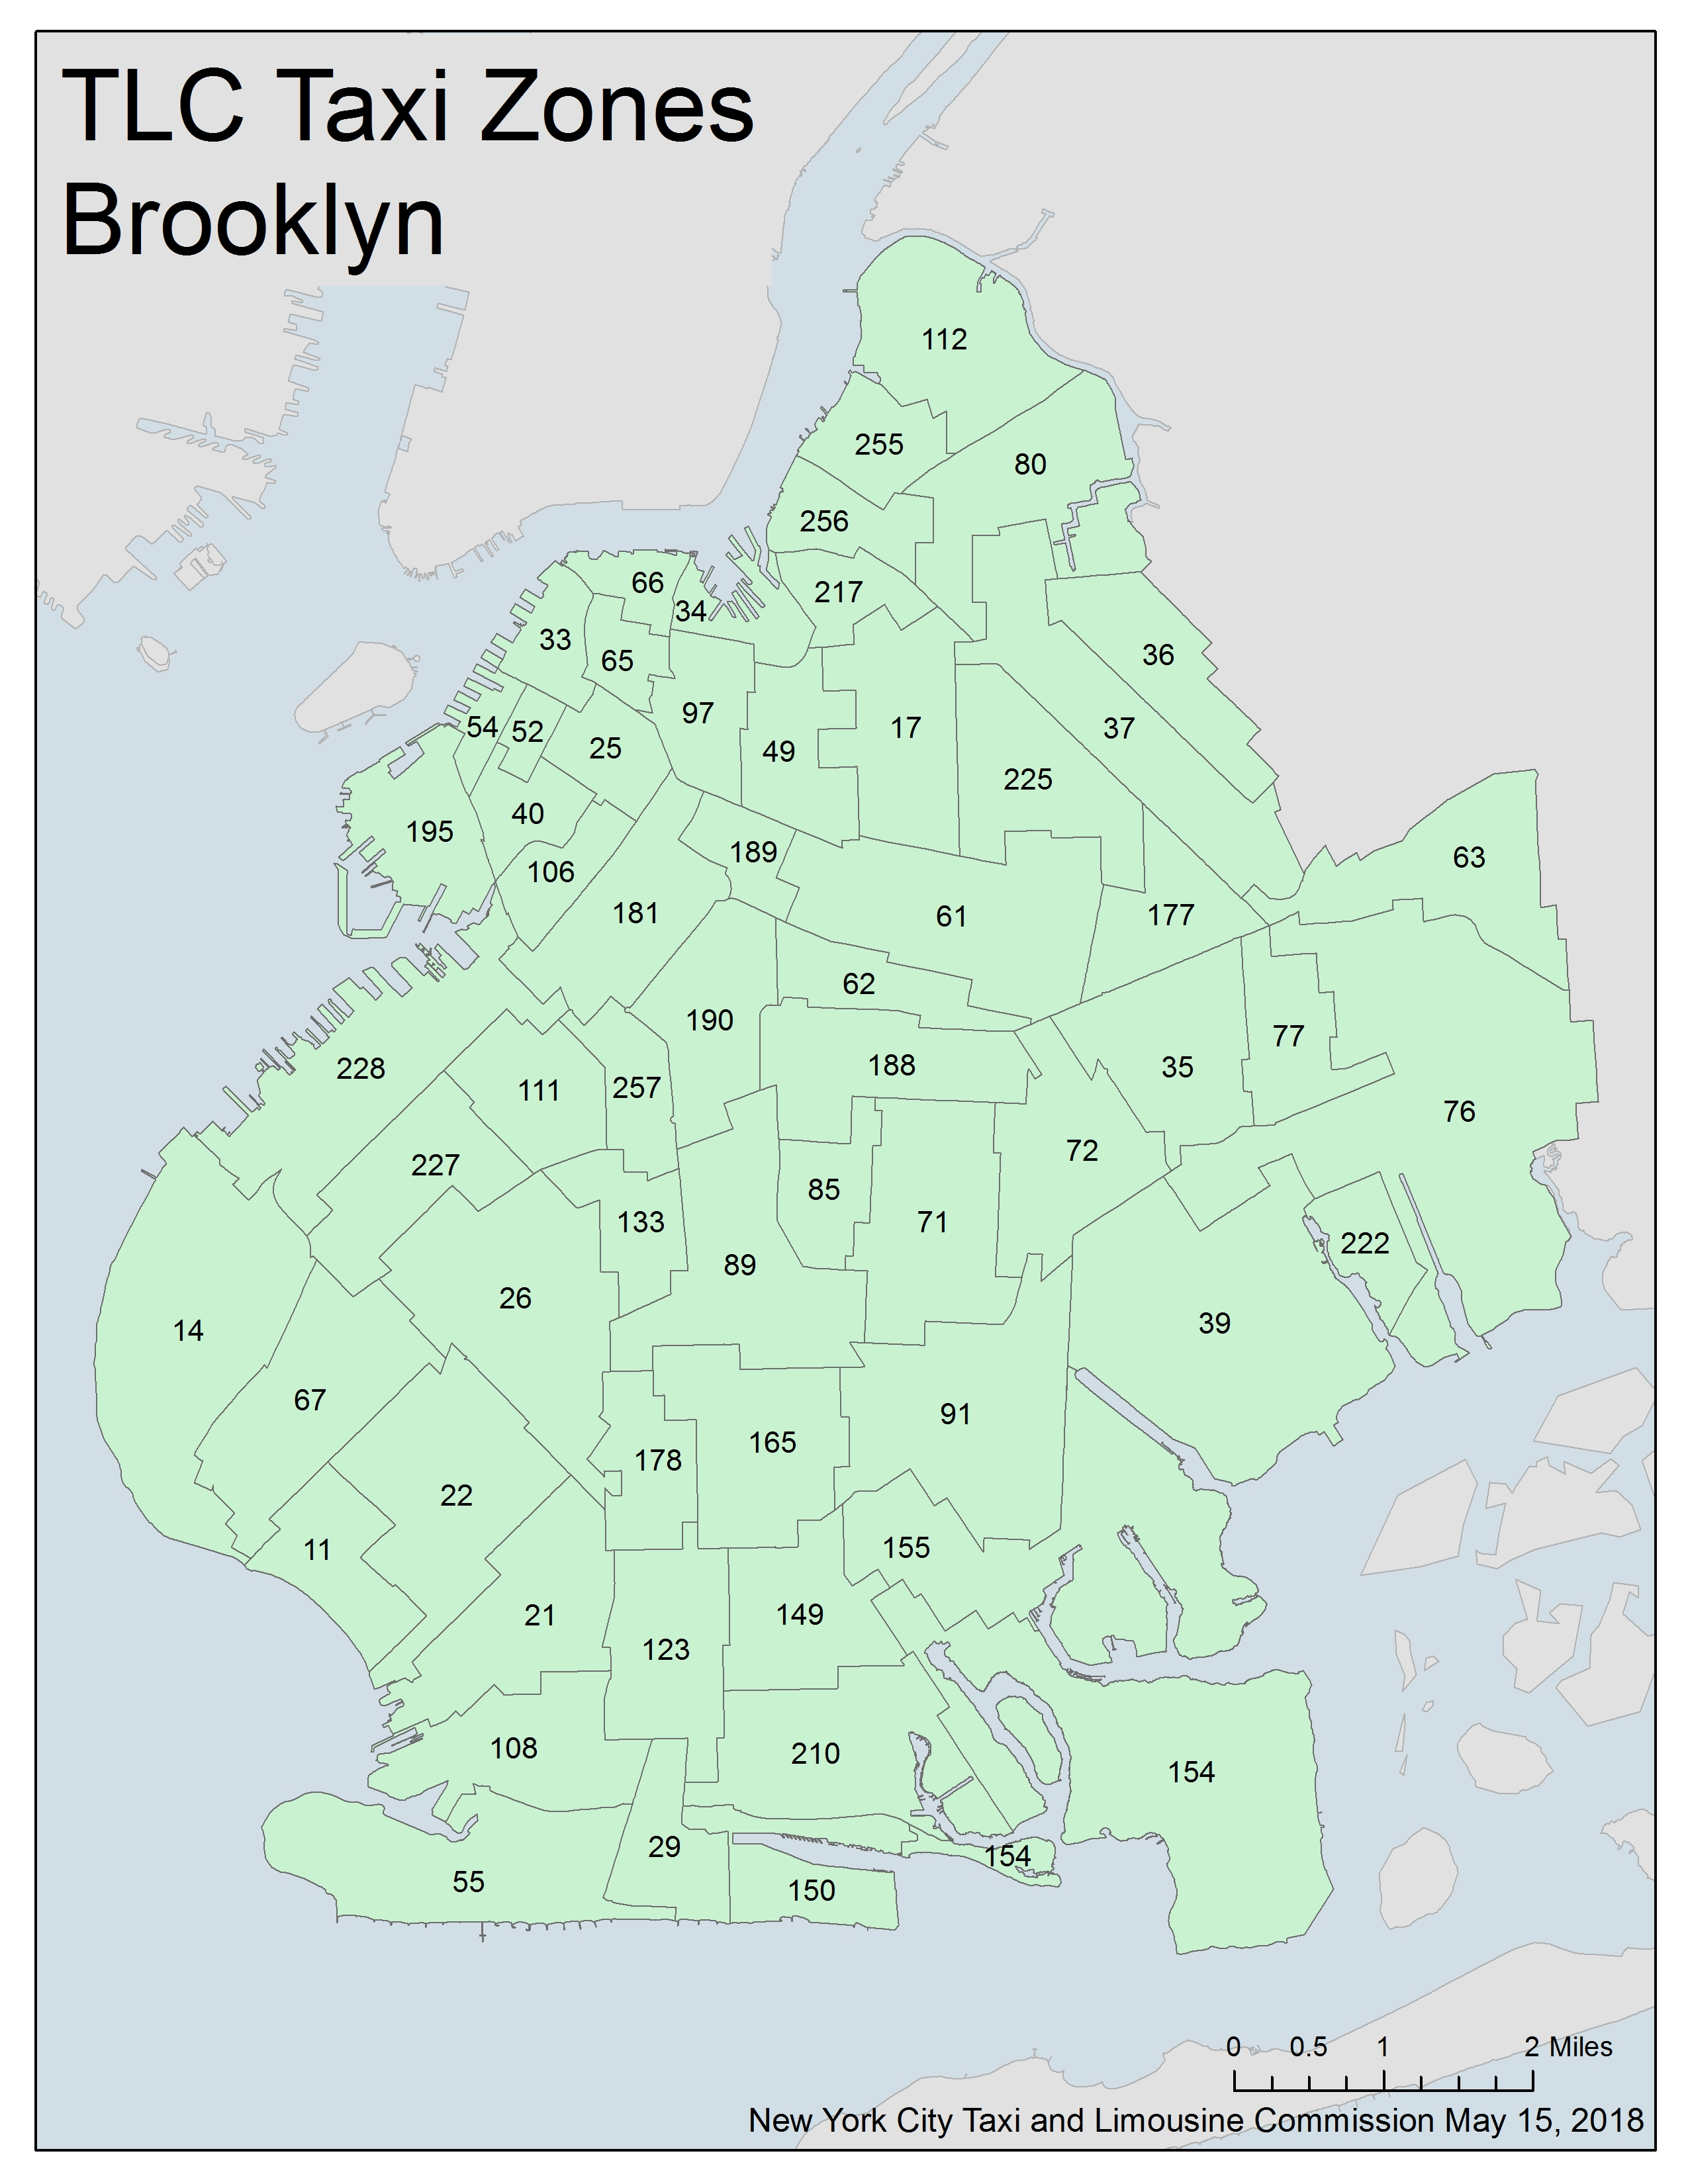

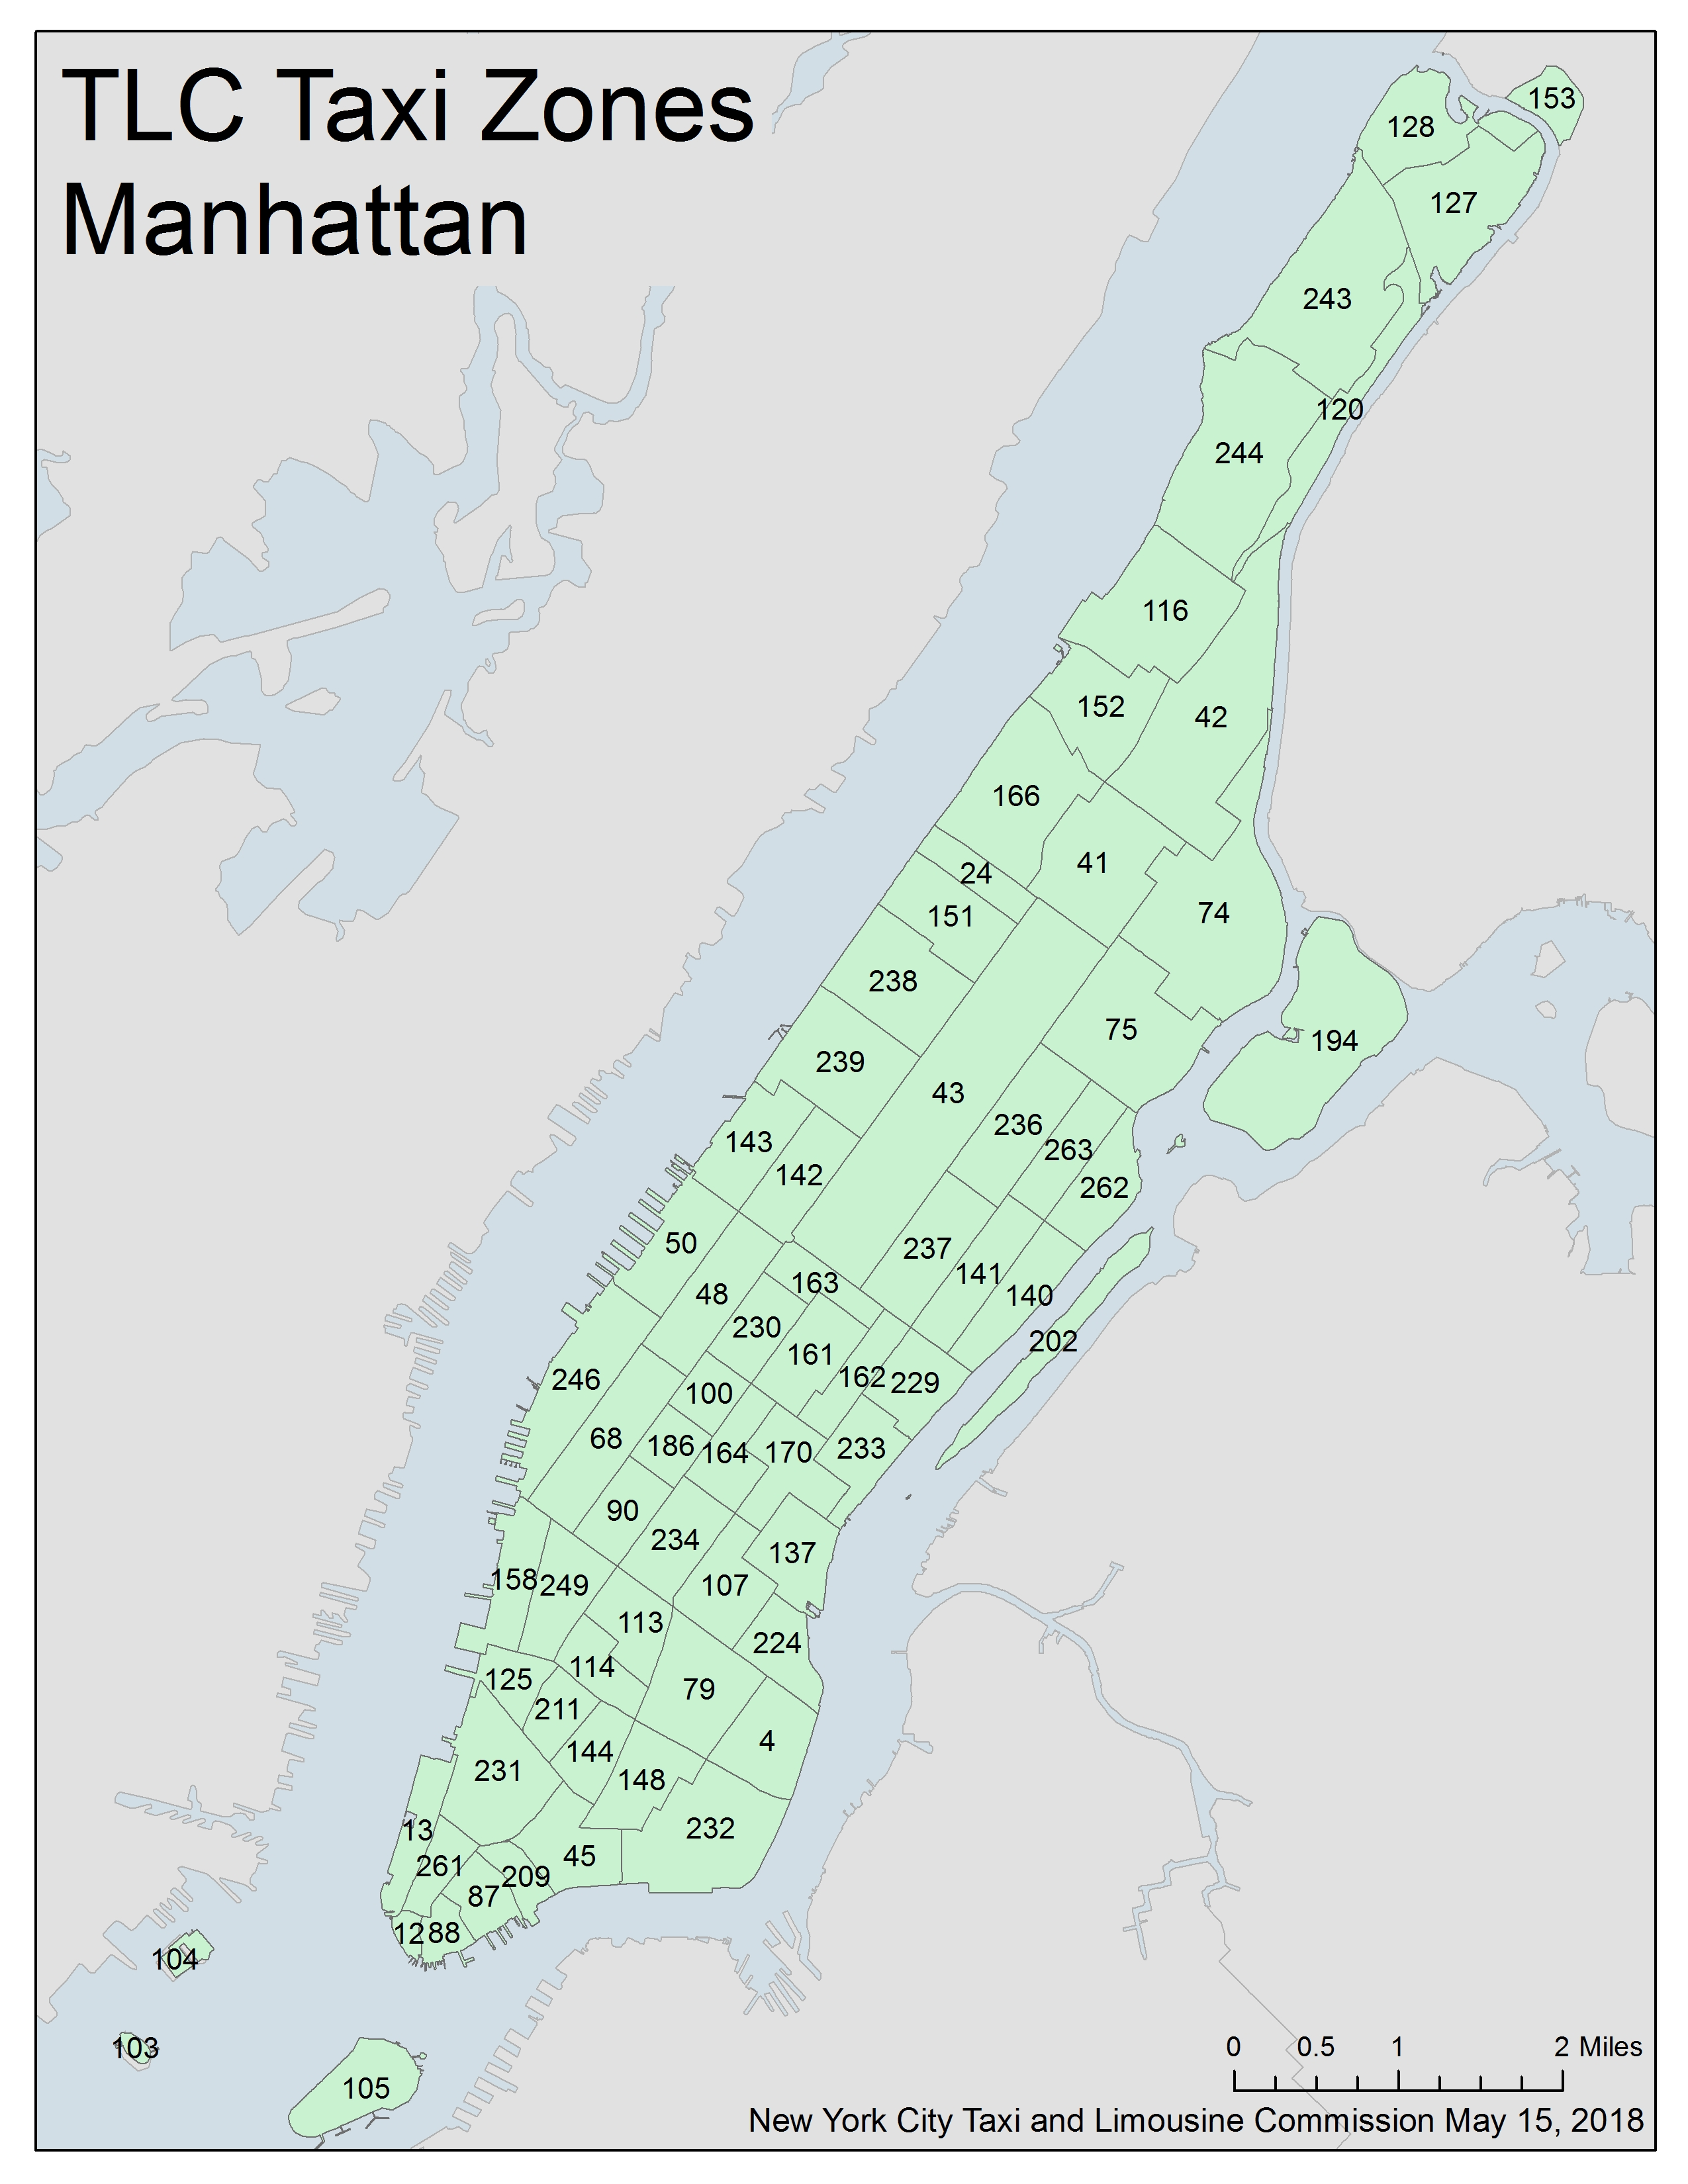

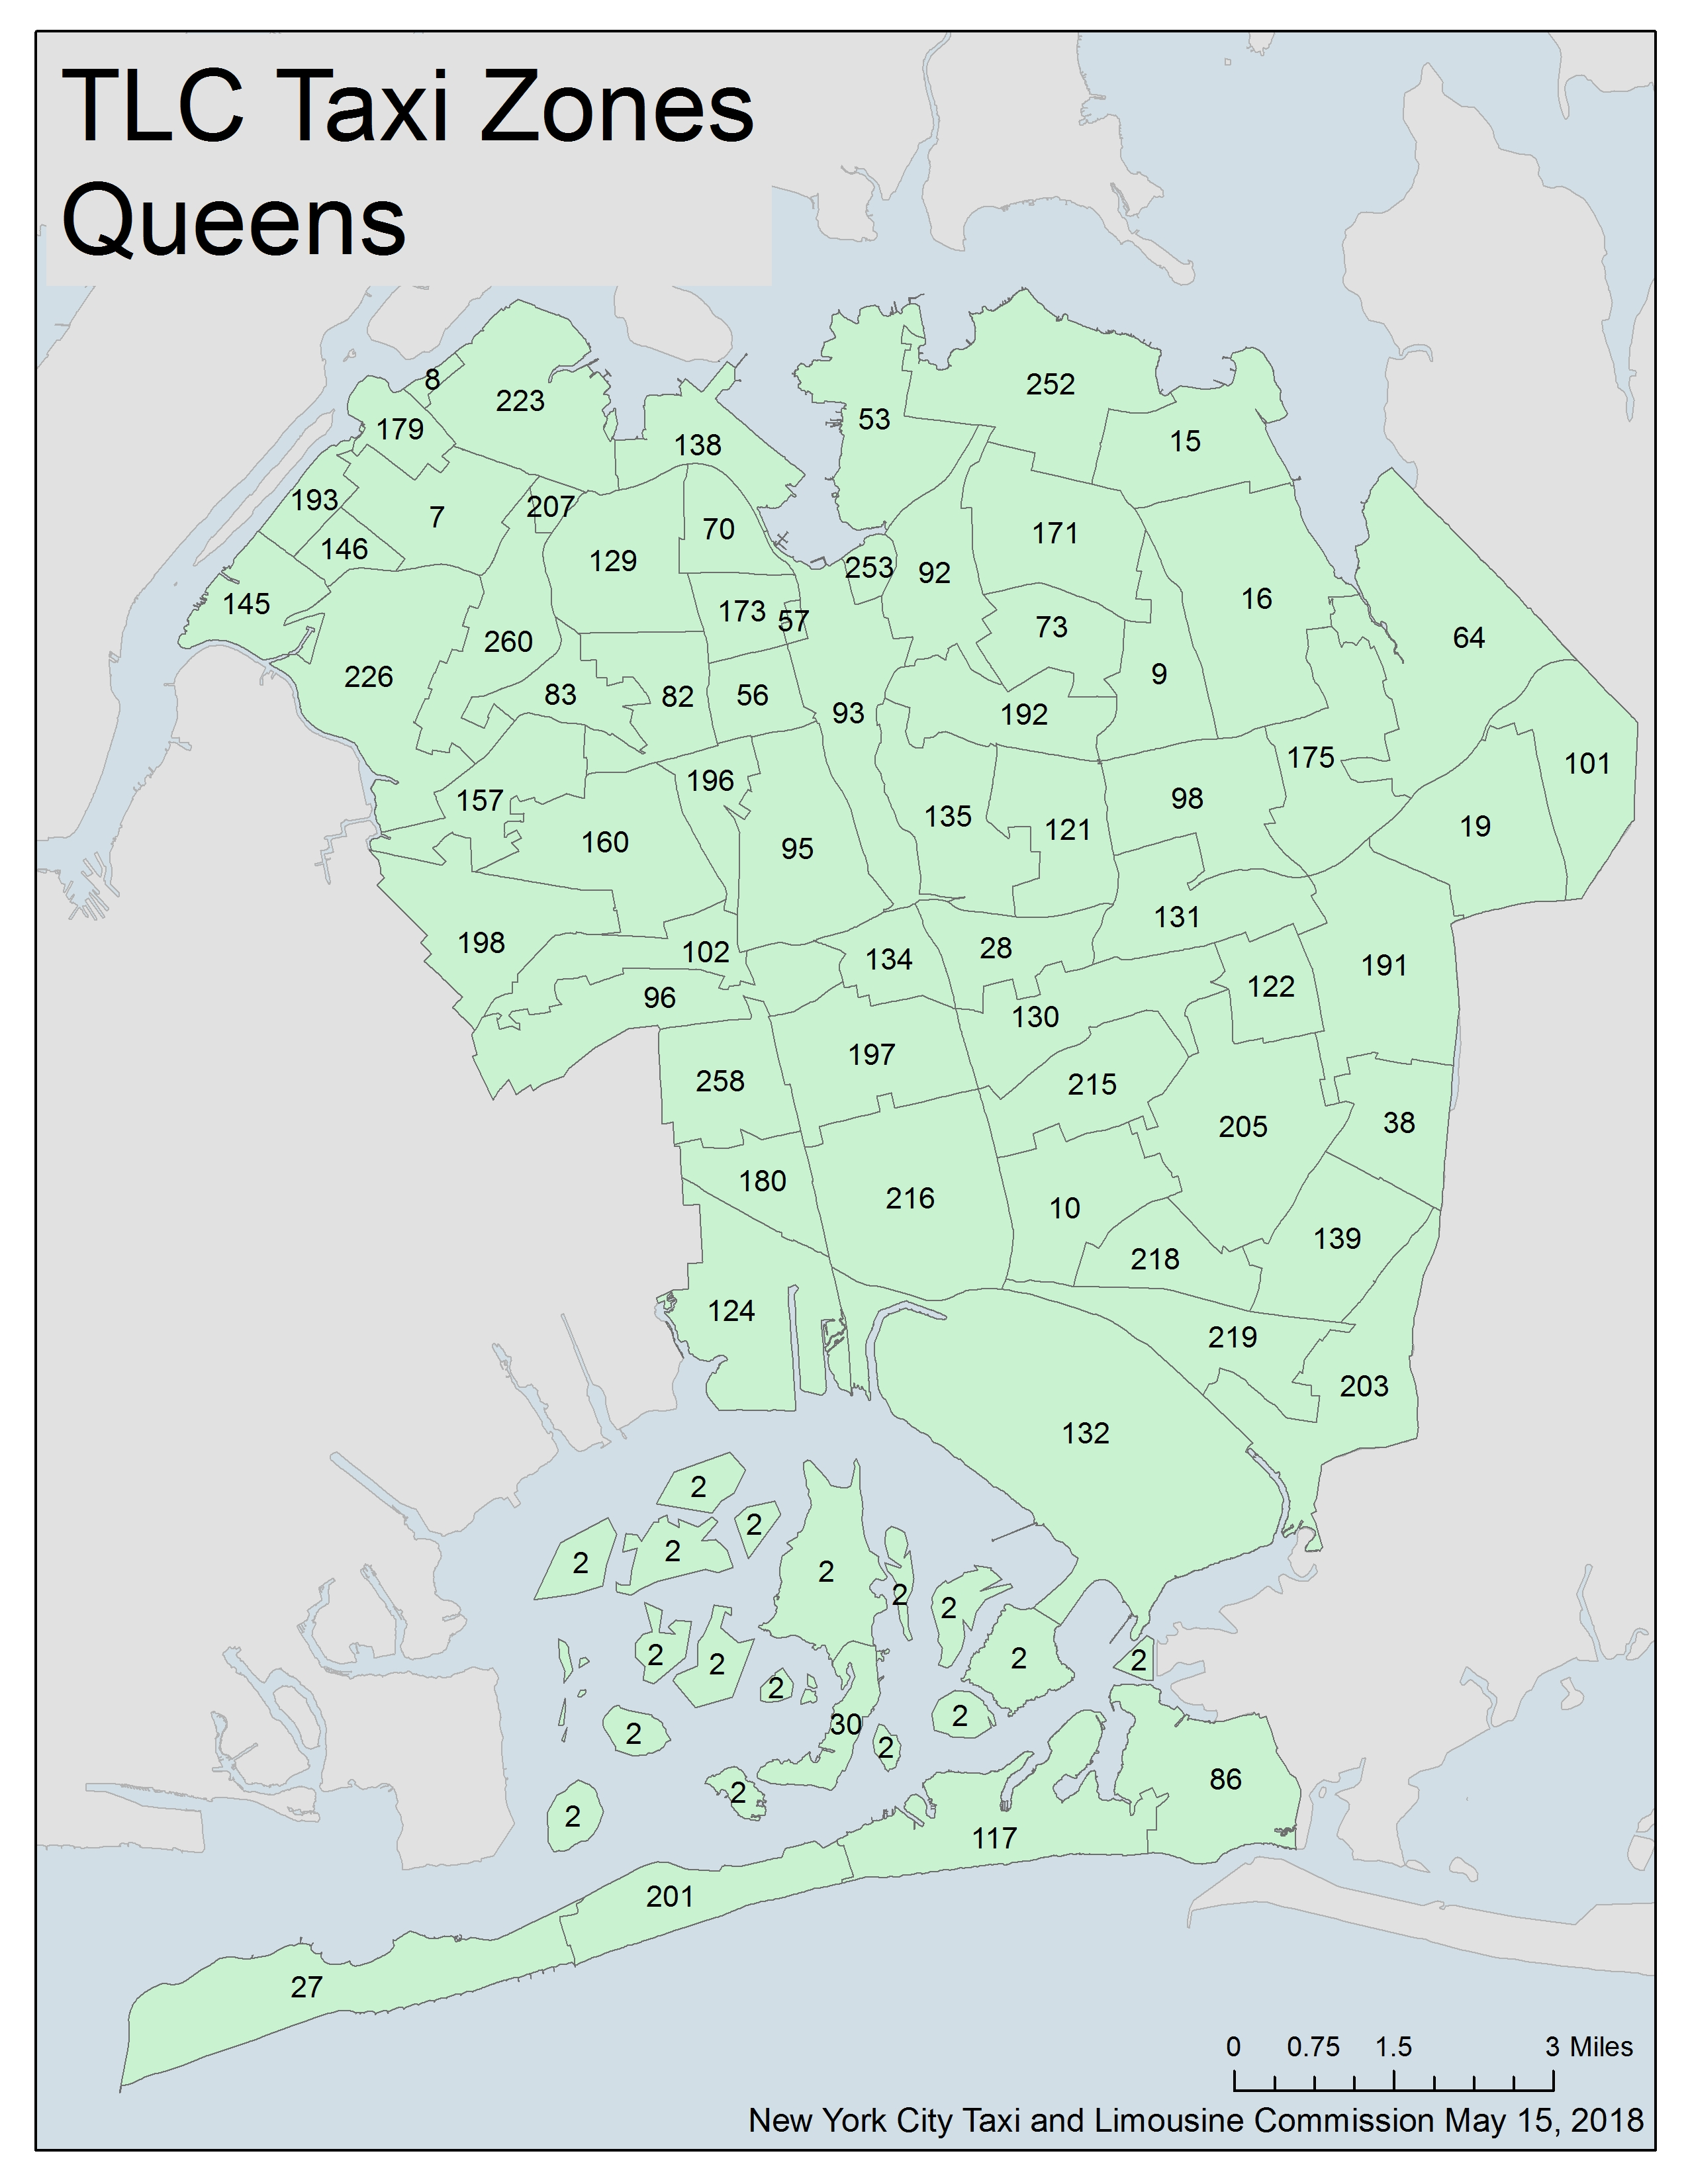

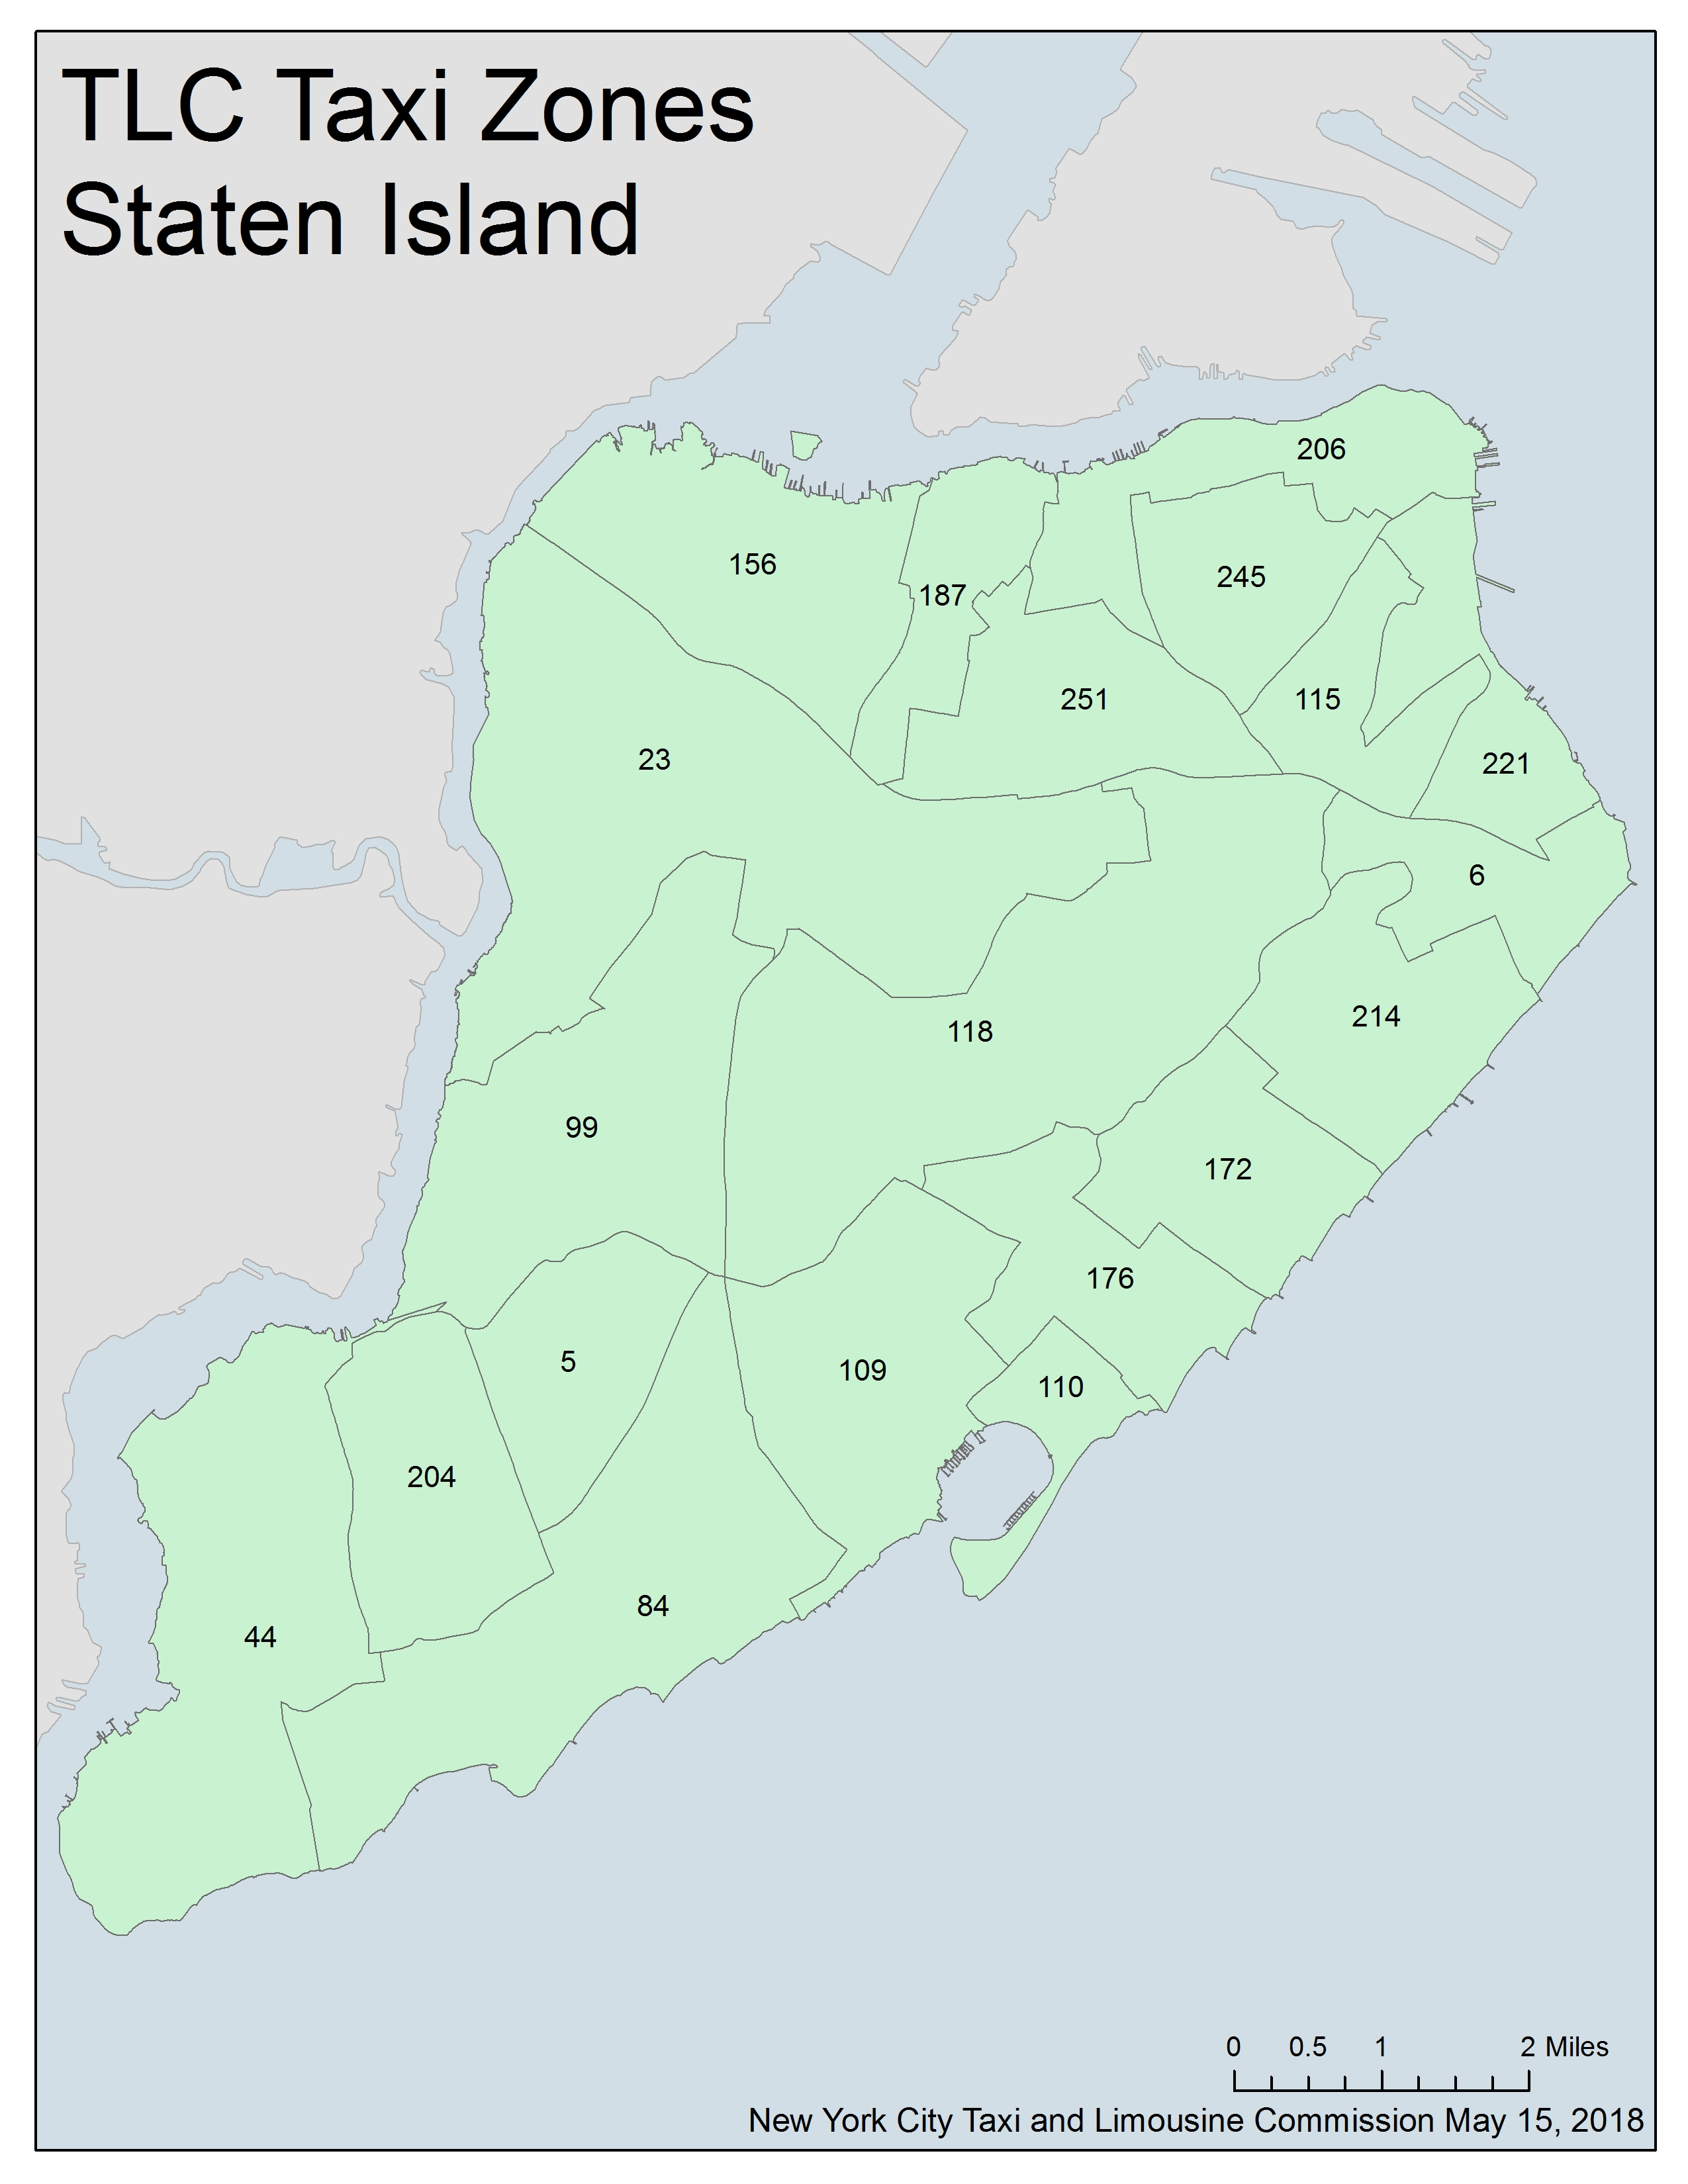

In [26]:
from IPython.display import Image, display

listOfImageNames = ['E:/GitHub/DS701-1904/week3/test/taxi_zone_map_bronx.jpg', 
                    'E:/GitHub/DS701-1904/week3/test/taxi_zone_map_brooklyn.jpg',
                    'E:/GitHub/DS701-1904/week3/test/taxi_zone_map_manhattan.jpg', 
                    'E:/GitHub/DS701-1904/week3/test/taxi_zone_map_queens.jpg',
                    'E:/GitHub/DS701-1904/week3/test/taxi_zone_map_staten_island.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName,width=600, height=600))

In [27]:
taxi_zone = pd.read_csv("E:/GitHub/DS701-1904/data/taxi+_zone_lookup.csv")

In [28]:
taxi_zone.head(10)

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone
5           6  Staten Island  Arrochar/Fort Wadsworth    Boro Zone
6           7         Queens                  Astoria    Boro Zone
7           8         Queens             Astoria Park    Boro Zone
8           9         Queens               Auburndale    Boro Zone
9          10         Queens             Baisley Park    Boro Zone

In [29]:
# int to object
taxi_zone['LocationID'] = taxi_zone['LocationID'].astype(str)

In [30]:
tmp = trips_cc.merge(taxi_zone[['LocationID', 'Borough']], 
                     left_on="PULocationID", right_on="LocationID", how="left")

# join dropoff
trips_merged = tmp.merge(taxi_zone[['LocationID', 'Borough']], 
                        left_on="DOLocationID", right_on="LocationID", how="left")
print(tmp)
# remove redundant features
trips_merged.drop(columns=["PULocationID", "DOLocationID", "LocationID_x", "LocationID_y"], axis=1, inplace=True)
# rename location features
trips_merged.rename(columns={"Borough_x":"PULocation", "Borough_y":"DOLocation"}, inplace=True)
# create a feature of whether pickup location is the same as drop off
# 1: different, 0: same
trips_merged["PU_DO"] = (trips_merged["PULocation"]!=trips_merged["DOLocation"]).astype(int)

       RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0               1           66           33              5.0           0.51   
1               1           25           49              5.0           1.97   
2               1           75          127              1.0           7.90   
3               1           36          112              2.0           2.90   
4               1          256           49              1.0           2.60   
5               1           25           28              2.0          14.64   
6               1          179          179              1.0           0.90   
7               1          179          179              2.0           0.90   
8               1            7          129              1.0           2.00   
9               1          256           17              2.0           1.10   
10              1           41          168              1.0           1.57   
11              1          112          225         

In [31]:
trips_merged.head()

RatecodeID  passenger_count  trip_distance  fare_amount  extra  mta_tax  \
0          1              5.0           0.51          4.0    0.5      0.5   
1          1              5.0           1.97          9.0    0.5      0.5   
2          1              1.0           7.90         24.0    0.5      0.5   
3          1              2.0           2.90         11.0    0.5      0.5   
4          1              1.0           2.60          9.5    0.5      0.5   

   tolls_amount  improvement_surcharge trip_type is_tipped  monthday  weekday  \
0           0.0                    0.3         1         1         1        5   
1           0.0                    0.3         1         1         1        5   
2           0.0                    0.3         1         1         1        5   
3           0.0                    0.3         1         1         1        5   
4           0.0                    0.3         1         1         1        5   

   hour  trip_duration  trip_speed PULocation DOLocation  PU_DO  
0     0       2.300000   13.304348   Brooklyn   Brooklyn      0  
1     0       9.166667   12.894545   Brooklyn   Brooklyn      0  
2     0      19.966667   23.739566  Manhattan  Manhattan      0  
3     0      12.150000   14.320988   Brooklyn   Brooklyn      0  
4     0       8.383333   18.608350   Brooklyn   Brooklyn      0

In [32]:
# join pickup
tmp = trips_cc.merge(taxi_zone[['LocationID', 'Borough']], 
                     left_on="PULocationID", right_on="LocationID", how="left")

# join dropoff
trips_merged = tmp.merge(taxi_zone[['LocationID', 'Borough']], 
                        left_on="DOLocationID", right_on="LocationID", how="left")

# remove redundant features
trips_merged.drop(columns=["PULocationID", "DOLocationID", "LocationID_x", "LocationID_y"], axis=1, inplace=True)
# rename location features
trips_merged.rename(columns={"Borough_x":"PULocation", "Borough_y":"DOLocation"}, inplace=True)
# create a feature of whether pickup location is the same as drop off
# 1: different, 0: same
trips_merged["PU_DO"] = (trips_merged["PULocation"]!=trips_merged["DOLocation"]).astype(int)

# label encoder pickup and dropoff location
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trips_merged['PULocation'])
trips_merged['PULocation'] = le.transform(trips_merged['PULocation'])
trips_merged['DOLocation'] = le.transform(trips_merged['DOLocation'])

### Binning (NOT APPLIED)

In [33]:
from pandas import qcut

# take the log transformation
log_features = ['trip_duration', 'trip_speed', 'trip_distance', 'fare_amount']
for f in log_features:
    trips_merged[f] = qcut(np.log(trips_merged[f]+0.01), q=6, labels=range(6))

### Binary (NOT APPLIED)

In [35]:
binary_features = ['mta_tax', 'improvement_surcharge', 'tolls_amount']

for f in binary_features:
    trips_merged[f] = (trips_merged[f]!=0).astype(int)

In [38]:
trips_merged.head(10)

RatecodeID  passenger_count trip_distance fare_amount  extra  mta_tax  \
0          1              5.0             0           0    0.5        1   
1          1              5.0             2           1    0.5        1   
2          1              1.0             5           4    0.5        1   
3          1              2.0             3           2    0.5        1   
4          1              1.0             3           2    0.5        1   
5          1              2.0             5           5    0.5        1   
6          1              1.0             0           0    0.5        1   
7          1              2.0             0           0    0.5        1   
8          1              1.0             2           2    0.5        1   
9          1              2.0             1           0    0.5        1   

   tolls_amount  improvement_surcharge trip_type is_tipped  monthday  weekday  \
0             0                      1         1         1         1        5   
1             0                      1         1         1         1        5   
2             0                      1         1         1         1        5   
3             0                      1         1         1         1        5   
4             0                      1         1         1         1        5   
5             0                      1         1         0         1        5   
6             0                      1         1         1         1        5   
7             0                      1         1         1         1        5   
8             0                      1         1         1         1        5   
9             0                      1         1         1         1        5   

   hour trip_duration trip_speed  PULocation  DOLocation  PU_DO  
0     0             0          3           1           1      0  
1     0             1          3           1           1      0  
2     0             4          5           3           3      0  
3     0             2          4           1           1      0  
4     0             1          5           1           1      0  
5     0             5          5           1           4      1  
6     0             0          2           4           4      0  
7     0             0          3           4           4      0  
8     0             2          2           4           4      0  
9     0             0          2           1           1      0

### LabelEncoder  (NOT APPLIED)

In [39]:
le = preprocessing.LabelEncoder()
le.fit(trips_merged['extra'])
trips_merged['extra'] = le.transform(trips_merged['extra'])

In [40]:
trips_merged.head()

RatecodeID  passenger_count trip_distance fare_amount  extra  mta_tax  \
0          1              5.0             0           0      1        1   
1          1              5.0             2           1      1        1   
2          1              1.0             5           4      1        1   
3          1              2.0             3           2      1        1   
4          1              1.0             3           2      1        1   

   tolls_amount  improvement_surcharge trip_type is_tipped  monthday  weekday  \
0             0                      1         1         1         1        5   
1             0                      1         1         1         1        5   
2             0                      1         1         1         1        5   
3             0                      1         1         1         1        5   
4             0                      1         1         1         1        5   

   hour trip_duration trip_speed  PULocation  DOLocation  PU_DO  
0     0             0          3           1           1      0  
1     0             1          3           1           1      0  
2     0             4          5           3           3      0  
3     0             2          4           1           1      0  
4     0             1          5           1           1      0

# Feature Selection (Optional)

When there are too many features and it is impossible to handle them manually, one way to solve the problem is to perform feature selection. Even though some models has feature selection functionality (LASSO), which is called embeded feature seletion, here we used filter method with two measure, Chi-square and F-score. 

Note that, in this dataset, the number of features is not large. Thus, feature selection might not increase the model performance.

In [61]:
from sklearn.feature_selection import chi2, f_classif

def selectFeatures(method, X, y, features):
    
    # method check
    if method not in ["chi2", "f"]:
        raise Exception("Only Chi2 and f score are supported.")
    if method == "chi2":
        score, _ = chi2(X, y)
    #输出的是chi2-value和p-value
    elif method == "f":
        score, _ = f_classif(X, y)
    score = np.nan_to_num(score)
    return sorted(zip(*(features, score)), key=lambda x: x[1], reverse=True)

In [62]:
# get X and y
features = [x for x in trips_merged.columns if x not in ['is_tipped']]
X = trips_merged[features].values
y = trips_merged['is_tipped'].values

# feature selection 
chi2 = selectFeatures('chi2', X, y, features)
f = selectFeatures('f', X, y, features)

# show results
chi2_df = pd.DataFrame(chi2, columns=['feature','chi2'])
f_df = pd.DataFrame(f, columns=['feature','f_score'])
merged_df = chi2_df.merge(f_df,on='feature',how='inner')

print(merged_df)

                  feature          chi2       f_score
0           trip_duration  39139.225796  36436.170502
1             fare_amount  37759.222243  32538.828024
2           trip_distance  23481.688686  21115.623411
3              DOLocation  11490.119365  15903.094988
4              PULocation   9771.564420  12004.980898
5                    hour   7214.213139   2832.719746
6                   extra   6621.930561   7013.306229
7            tolls_amount   5046.070744   5369.459423
8                 weekday   2729.582280   3040.441017
9                   PU_DO   1659.205086   2089.461372
10               monthday   1554.792150    314.334577
11             trip_speed    501.981582    430.707334
12             RatecodeID     79.004802    497.325271
13  improvement_surcharge      7.292530    738.895715
14              trip_type      7.116946    727.847097
15                mta_tax      6.706665    641.137636
16        passenger_count      0.903149      1.119035


In [63]:
trips_merged.drop(["passenger_count"], axis=1, inplace=True)

For both of the feature selection methods, variables `passenger_count` has relatively low scores and I just removed them. 

In [64]:
trips_merged.head()

RatecodeID trip_distance fare_amount  extra  mta_tax  tolls_amount  \
0          1             0           0      1        1             0   
1          1             2           1      1        1             0   
2          1             5           4      1        1             0   
3          1             3           2      1        1             0   
4          1             3           2      1        1             0   

   improvement_surcharge trip_type is_tipped  monthday  weekday  hour  \
0                      1         1         1         1        5     0   
1                      1         1         1         1        5     0   
2                      1         1         1         1        5     0   
3                      1         1         1         1        5     0   
4                      1         1         1         1        5     0   

  trip_duration trip_speed  PULocation  DOLocation  PU_DO  
0             0          3           1           1      0  
1             1          3           1           1      0  
2             4          5           3           3      0  
3             2          4           1           1      0  
4             1          5           1           1      0

# Predictive Modeling

In [65]:
# Sample for the livecoding
trips_sample = trips_merged.sample(frac=0.1, random_state=42)

We trained a classification model, to determine if a trip will be tipped or not. Follow the instructions below. 

* Get X and y from `trips_cc` dataframe.
* Split data into train/test, 80000 test.
* Model selection. Use training set to run cross validation on all classification models and choose top two.
* Fine tune three models using `RandomizedSearchCV`.
* Show feature importance.
* Ensemble three models using majority vote.
* Stacking three models using `StackingCVClassifier`.
* Compare all five models on test set.

## Train Test Split

In [68]:
# get X and y

y = trips_sample['is_tipped'].values
X = trips_sample.drop(['is_tipped'], axis=1).values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
X_train.shape

(33240, 16)

## Model Selection

First roughly train Logistic Regression, Decision Tree, Random Forest, XGBoost, ..., using 3-fold cross validation. 

In [70]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
import time

# 9 candidate models
models = [LogisticRegression, 
          DecisionTreeClassifier, 
          RandomForestClassifier,
          AdaBoostClassifier,
          XGBClassifier,
          KNeighborsClassifier,
          ExtraTreesClassifier]

labels = ['lr','dt','rf','ada','xgb','knn','et']

print('5-fold cross validation:\n')
# train models
for model, label in zip(models,labels):
    scores = cross_val_score(model(), X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.7200 (+/- 0.0008) [lr]
Accuracy: 0.6617 (+/- 0.0007) [dt]
Accuracy: 0.7197 (+/- 0.0028) [rf]
Accuracy: 0.7533 (+/- 0.0028) [ada]
Accuracy: 0.7675 (+/- 0.0043) [xgb]
Accuracy: 0.7215 (+/- 0.0022) [knn]
Accuracy: 0.7063 (+/- 0.0031) [et]


From the results above, we would like to choose Logistic Regression, Random Forest, AdaBoost, XGBoost, KNN and Extra Trees. Then, we used [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to tune hyperparameters. 

## Tune Hyperparameters

To tune hyperparameters, for each model we need to set up several hyperparameters as well as their possible values. For example, in Random Forest, `n_estimators` is the number of trees. Possible values are `np.arange(50,300,30)`. There are also `max_depth` and `min_samples_split`. 

After we prepared for the hyperparameters, `GridSearchCV` will go through all possible combinations. During hyperparameter tuning, we also stored the best estimator, best parameters, best accuracy and running time to make comparison. 

**Note:** It might be running about several hours for the current setttings.

In [108]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # RandomizedSearchCV中n_iter = 60 --> 95% cover optimal combination

# Logistic Regression
lr_params = {
    'C': [0.1,0.3,0.5,0.7,0.9], # smaller values specify stronger regularization, more complicated model
    'penalty': ['l1','l2'] # specify the norm used in the penalization
}

# Random Forest hyperparameters
rf_params = {
    'n_estimators': [300,400,500],
    'max_depth': [None],
    'min_samples_split': [3,5,7],
    'min_samples_leaf':[2,3,4]
}

# AdaBoost hyperparameters
ada_params = {
    'n_estimators':[300,400,500],
    'learning_rate':[0.3]
}

# XGBoost hyperparameters
xgb_params = {
    'n_estimators':[200,250,300,350,400,450,500],
    'learning_rate':[0.1,0.2,0.3,0.4,0.5],
    'max_depth':[3,4,5,6,7],
    'min_child_weight':[2],
    'gamma':[0.2,0.3,0.4],
    'subsample':[0.5,0.6,0.7,0.8]
}

# K Nearest Neighbor Classifier
knn_params = {
    'n_neighbors':[5],
    'leaf_size':[2,4],
    'algorithm':['kd_tree'] 
}

# Extra Trees Parameters
et_params = {
    'n_estimators':[300,400,500],
    'max_depth': [None],
    'min_samples_split': [3],
    'min_samples_leaf':[2]
}

# models
lr_clf = LogisticRegression
rf_clf = RandomForestClassifier
ada_clf = AdaBoostClassifier
xgb_clf = XGBClassifier
knn_clf = KNeighborsClassifier
et_clf = ExtraTreesClassifier

# pairs list
# pairs list
clf_params = [(lr_clf,lr_params),
              (rf_clf,rf_params),
              (ada_clf,ada_params),
              (xgb_clf,xgb_params),
              (knn_clf,knn_params),
              (et_clf,et_params)]

In [109]:
# hyperparameter tuning
tune_results = {}

for clf, params in clf_params:
    
    start = time.time()
    tune = GridSearchCV(clf(),params,scoring="accuracy",cv=3,verbose=True,n_jobs=-1)
    tune.fit(X_train, y_train)
    best_estimator = tune.best_estimator_
    best_params = tune.best_params_
    best_score = tune.best_score_
    tune_results[clf] = (best_estimator, best_params, best_score, (time.time()-start)/60)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   15.8s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.6min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   52.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.3min finished


Fitting 3 folds for each of 2100 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 68.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 95.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 123.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 157.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 195.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 235.6min
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed: 247.9min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.7s finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.2s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   24.5s finished


In [110]:
# Show results of tuning hyperparameters
tune_results

{sklearn.linear_model.logistic.LogisticRegression: (LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False),
  {'C': 0.9, 'penalty': 'l2'},
  0.720216606498195,
  0.27860451141993203),
 sklearn.ensemble.forest.RandomForestClassifier: (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=4, min_samples_split=3,
                         min_weight_fraction_leaf=0.0, n_estimators=400,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, war

Each model improves significantly after hyperparameter tuning, compared with the training by default settings. The performance for these three models can be improved further, if we put more possible parameter settings, which will also increase the running time.

## Feature Importance

Another advantage of choosing those three models is that all of them has method `feature_importances_`. We drew three feature importance curves together in a single figure. 

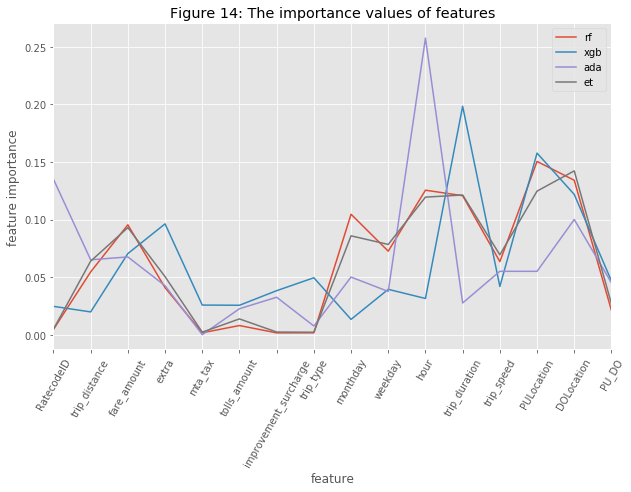

In [111]:
predictors = [x for x in trips_merged.columns if x != 'is_tipped']
# show feature importances
feature_importance = pd.DataFrame(predictors, columns=['feature'])
feature_importance['rf'] = tune_results[rf_clf][0].feature_importances_
feature_importance['xgb'] = tune_results[xgb_clf][0].feature_importances_
feature_importance['ada'] = tune_results[ada_clf][0].feature_importances_
feature_importance['et'] = tune_results[et_clf][0].feature_importances_
feature_importance.plot(x='feature',y=['rf','xgb','ada','et'],xticks=range(len(predictors)),rot=60,figsize=(10,6))
plt.ylabel('feature importance')
plt.title("Figure 14: The importance values of features")
plt.show()

## Stacking

In this section, we implemented stacking from scratch. Each individual classifier has the best parameters given by section 5.3. The meta classifier is Logistic Regression with default parameters. 

First, we got prediction values from these models, using cross validation. Note that, at the same time we should convert your test set into the format you need. 

The function 
```Python
def get_oof()
```
helps to implement the cross validation.

In [112]:
from sklearn.model_selection import KFold
import scipy

def get_oof(clf, x_train, y_train, x_test):
    
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    kf = KFold(n_splits= 3, random_state=42)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((3, ntest))
    i = 0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        i += 1
   
    oof_test[:] = scipy.stats.mode(oof_test_skf, axis=0)[0]
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Then we used the optimal parameters obtained in section 5.3 to train models and get stacked dataseet.

In [113]:
stack_train = []
stack_test = []

for clf, _ in clf_params:
    tmp = clf(**tune_results[clf][1])
    oof_train, oof_test = get_oof(tmp, X_train, y_train, X_test)
    stack_train.append(oof_train)
    stack_test.append(oof_test)
    
X_train_stacked = np.concatenate(stack_train, axis=1)
X_test_stacked = np.concatenate(stack_test, axis=1)

# meta classifier
metas = {}

#其实meta classifier只用logistic regression就可以
for clf, _ in clf_params:
    metas[clf] = clf().fit(X_train_stacked, y_train)

## Ensemble

Ensemble all the model results together, including individuals and stacking, from scratch. 

In [114]:
#Stacking后其实没有必要再做Ensemble因为相关性已经很强了，即使错也是错一样的
ensemble_res = []

for clf, _ in clf_params:
    ensemble_res.append(metas[clf].predict(X_test_stacked))
    ensemble_res.append(tune_results[clf][0].predict(X_test))

In [115]:
import scipy

# make prediction
ensemble_arr = np.array(ensemble_res).astype(np.int)
ensemble_pred = scipy.stats.mode(ensemble_arr, axis=0)[0][0,:].astype(np.str)

In [116]:
ensemble_pred

array(['1', '1', '0', ..., '1', '1', '0'], dtype='<U11')

## On Test Set

Now, we have six individual models, six stacking models and one ensemble model. Apply all models on test set, and compute accuracy scores.

In [117]:
# individuals,
model_labels = ['lr','rf','ada','xgb','knn','et']
all_clfs = [x[0] for x in clf_params]

for clf, label in zip(all_clfs, model_labels):
    print ("Accuracy: %0.4f [%s]" %(tune_results[clf][0].score(X_test,y_test), label))
    
# stacking
stack_labels = ['lr_stack','rf_stack','ada_stack','xgb_stack','knn_stack','et_stack']

for clf, label in zip(all_clfs, stack_labels):
    print ("Accuracy: %0.4f [%s]" %(metas[clf].score(X_test_stacked,y_test), label))

# ensemble
from sklearn.metrics import accuracy_score
print ("Accuracy: %0.4f [%s]" %(accuracy_score(y_test, ensemble_pred), "ensemble"))
#XGBoost是在样本量大，tuning hyperparameter tune多的时候表现的最好

Accuracy: 0.7260 [lr]
Accuracy: 0.7758 [rf]
Accuracy: 0.7526 [ada]
Accuracy: 0.7730 [xgb]
Accuracy: 0.7268 [knn]
Accuracy: 0.7685 [et]
Accuracy: 0.7739 [lr_stack]
Accuracy: 0.7744 [rf_stack]
Accuracy: 0.7744 [ada_stack]
Accuracy: 0.7740 [xgb_stack]
Accuracy: 0.7647 [knn_stack]
Accuracy: 0.7751 [et_stack]
Accuracy: 0.7742 [ensemble]


# Conclusion

We used 6 classification models to fit green taxi data, to classify whether a trip will be tipped or not. During model selection, Random Forest, AdaBoost and XGBoost outperformed. This is reasonable, since they are all complicated models. Logistic Regression and Decision Tree are too simple, and somehow underfitting the data. 

We fine tuned these models and get the following results.

|model|best params|best accuracy|run time(mins)|
|-----|-----------|--------|--------|
|Logistic Regression|{'C': 0.9, 'penalty': 'l2'}|0.7202| 0.28|
|Random Forest|{'min_samples_leaf': 4,'min_samples_split': 3,'n_estimators': 400}|0.7709| 2.81|
|XGBoost|{'learning_rate': 0.2,'min_child_weight': 2,'n_estimators': 200}|0.7732|248.04|
|AdaBoost|{'learning_rate': 0.3, 'n_estimators': 400}|0.7552|2.24|
|KNN|{'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 5}|0.7227|0.035|
|Extra Trees|{'min_samples_leaf': 2,'min_samples_split': 3,'n_estimators': 400}|0.7664|0.58|

XGBoost gets the best performance among these models in the training data. 

For feature importances, pickup/dropoff location and trip duration are more important than other features. The results make sense. First of all, it is more likely that a long trip will be tipped than a short trip. Second, people  in a certain fixed area may be more likely to give tips, for example, pick up location is airport.

In addition, we used stacking and ensemble methods to combine models together. The predictive performances on test set are as follows.

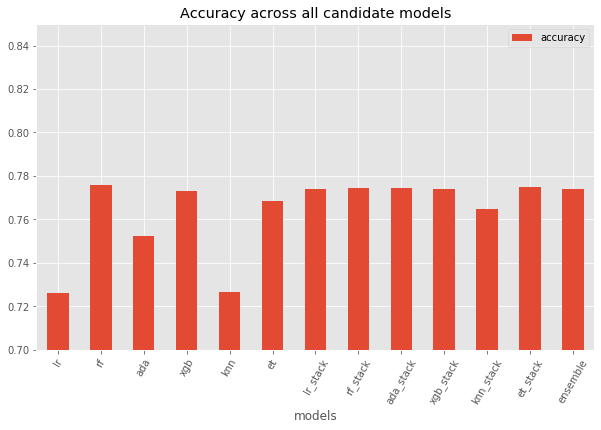

In [58]:
final_res = pd.DataFrame()
final_res['models'] = ['lr','rf','ada','xgb','knn','et' ,
                       'lr_stack' ,'rf_stack','ada_stack','xgb_stack','knn_stack','et_stack' ,
                       'ensemble']
final_res['accuracy'] = [0.7260, 0.7758, 0.7526, 0.7730, 0.7268, 0.7685,
                        0.7739, 0.7744, 0.7744, 0.7740, 0.7647, 0.7751, 0.7742]
final_res.plot.bar(x='models',y='accuracy',rot=60,figsize=(10,6))
plt.ylim(0.7,0.85)
plt.title("Accuracy across all candidate models")
plt.show()

|model|accuracy|
|-----|-----------|
|lr        | 0.7260 |
|rf        | 0.7758 |
|ada       | 0.7526 |
|xgb       | 0.7730 |
|knn       | 0.7268 |
|et        | 0.7685 |
|lr_stack  | 0.7739 |
|rf_stack  | 0.7744 |
|ada_stack | 0.7744 |
|xgb_stack | 0.7740 |
|knn_stack | 0.7647 |
|et_stack  | 0.7751 |
|ensemble  | 0.7742 |

The result shows that Random Forest method is promising. 

In some Data Challenge projects or Kaggle, a good result heavily relies on the condition of your dataset. Sometimes a simple model such as Logistic Regression outperforms other complicated models. Sometimes stacking and ensemble do not make much difference. Model tuning is also very dependent on experience. There is no right or wrong solution. All I have to do is practice more. 

